In [1]:
import largestinteriorrectangle as lir
import cv2
import numpy as np

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from natsort import natsorted
from glob import glob

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def psnr_ssim_rect(orig_img, rectified_img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(rectified_img, cv2.COLOR_BGR2GRAY)
    # Threshold the image to create a binary image (black and white)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    grid = thresh.astype(np.bool)

    rectangle = lir.lir(grid)
    
    (x_min, y_min) = lir.pt1(rectangle)
    (x_max, y_max) = lir.pt2(rectangle)

    # Crop the image using the inscribed rectangle's coordinates
    cropped_img = orig_img[y_min:y_max, x_min:x_max]
    cropped_img_rect = rectified_img[y_min:y_max, x_min:x_max]

    
    psnr_out = psnr(cropped_img, cropped_img_rect)
    ssim_out = ssim(cropped_img, cropped_img_rect, multichannel=True)

    return (psnr_out, ssim_out)

In [3]:
import sys
import os

cwd = os.getcwd()
print(cwd)

/Users/vanple/Desktop/ucla/_Courses_/3D-vis-reasoning/stage2/stage2_stereo


In [4]:
left_files = natsorted(glob(cwd + '/left_imgs/*.png'))
right_files = natsorted(glob(cwd + '/right_imgs/*.png'))
dis_files = natsorted(glob(cwd + '/disparities/*.png'))

left_file = left_files[0]
right_file = right_files[0]
dis_file = dis_files[0]

In [17]:
block_size = np.arange(5, 51, 2)
max_disp = [16, 32, 64, 128, 256]
rmse_sum = 0

# Initialize variables to store the best parameters and the best score
best_block_size = None
best_max_disparity = None
best_score = float('inf')

In [6]:
left_img = cv2.imread(left_file, 0)
right_img = cv2.imread(right_file, 0)
dis_gt_img = cv2.imread(dis_file, 0).astype(np.float32)

In [18]:
for bs in block_size:
    for md in tqdm(max_disp):
        stereo = cv2.StereoBM_create(numDisparities=md, blockSize=bs)
        disparity = stereo.compute(left_img, right_img)
        disparity = cv2.normalize(disparity, None, alpha=0, beta=md, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        # error
        mask = np.logical_or(disparity == 0, dis_gt_img == 0)
        masked_sq_err = np.ma.array(np.square(disparity - dis_gt_img), mask=mask)
        rmse = np.sqrt(masked_sq_err.mean())

        if rmse < best_score: 
            best_score = rmse
            best_block_size = bs
            best_max_disparity = md

100%|██████████| 5/5 [00:00<00:00, 20.06it/s]


In [19]:
print('Best block size: ', best_block_size, 'and best max disparity: ', best_max_disparity, 'best score: ', best_score)

Best block size:  47 and best max disparity:  64 best score:  2.663160724511975


In [20]:
best_stereo = cv2.StereoBM_create(numDisparities=best_max_disparity, blockSize=best_block_size)
best_disparity = stereo.compute(left_img, right_img)
best_disparity = cv2.normalize(disparity, None, alpha=0, beta=best_max_disparity, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

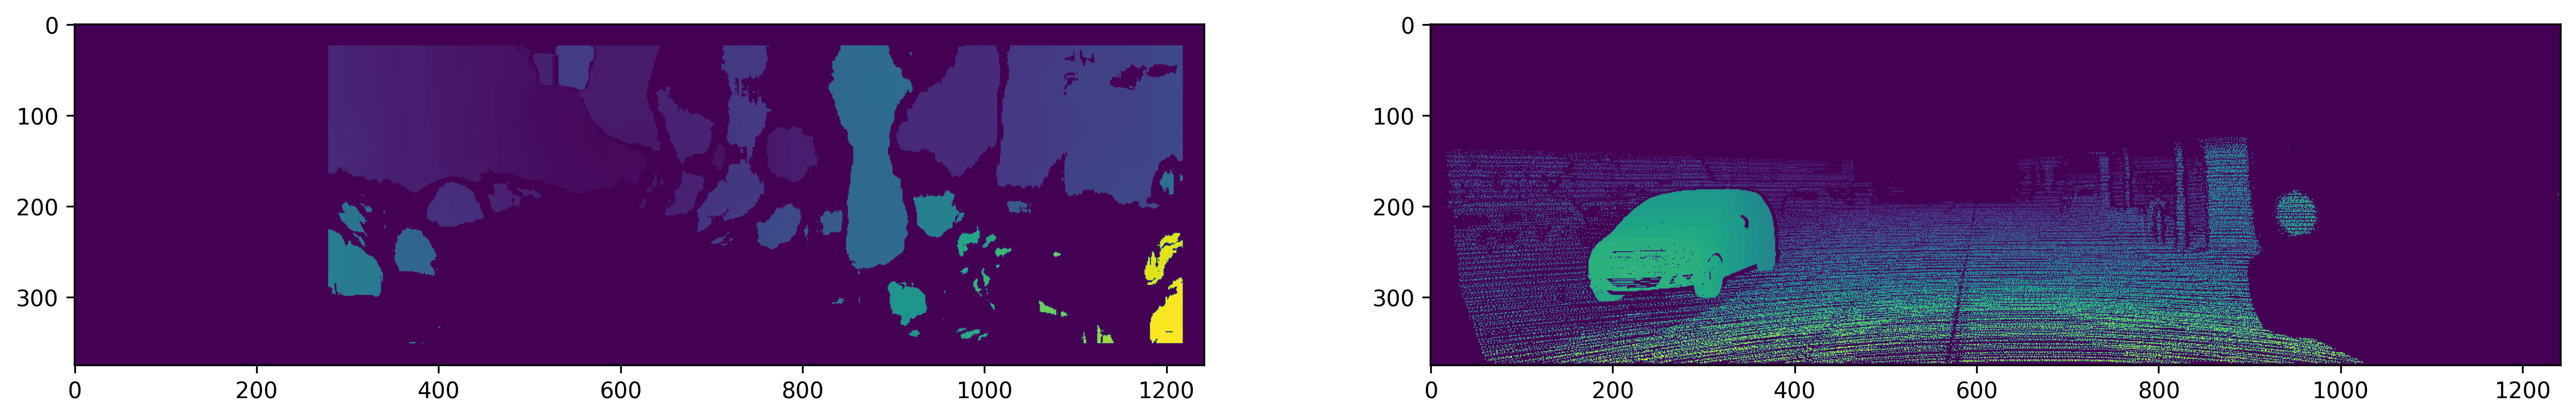

In [21]:
fig = plt.figure(figsize=(20, 20), dpi=300)
fig.add_subplot(1, 2, 1)
plt.imshow(best_disparity)
fig.add_subplot(1, 2, 2)
plt.imshow(dis_gt_img)
plt.show()